In [2]:
!pip install lightgbm

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/5e/23/f8b28ca248bb629b9e08f877dd2965d1994e1674a03d67cd10c5246da248/lightgbm-4.6.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
    --------------------------------------- 0.0/1.5 MB ? eta -:--:--
    --------------------------------------- 0.0/1.5 MB 1.3 MB/s eta 0:00:02
   - -------------------------------------- 0.0/1.5 MB 393.8 kB/s eta 0:00:04
   --- ------------------------------------ 0.1/1.5 MB 819.2 kB/s eta 0:00:02
   --- ------------------------------------ 0.1/1.5 MB 654.9 kB/s eta 0:00:03
   ----- ---------------------------------- 0.2/1.5 MB 908.0 kB/s eta 0:00:02
   ------- -------------------------------- 0.3/1.5 MB 1.1 MB/s eta 0:00:02
   -------- ------------------------------- 0.3/1.5 MB 1.2 MB/s eta 0:00:01
   ------------- -------------------------- 0.5/1.5 MB 1.7 MB/s eta 0:00:01
   -------------- ---------------------


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance
import tldextract
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")  

data = pd.read_csv('Malicious-URLs.csv')
# Удаление дубликатов и пустых значений
data = data.drop_duplicates(subset="url").dropna()

# Проверка баланса классов
print("Распределение классов:")
print(data["label"].value_counts())
data

Распределение классов:
label
benign        10991
defacement     2727
phishing        912
malware         303
Name: count, dtype: int64


,count,url,label
0,0,br-icloud.com.br,phishing
1,1,mp3raid.com/music/krizz_kaliko.html,benign
2,2,bopsecrets.org/rexroth/cr/1.htm,benign
3,3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...,...
14995,14995,fortdefianceind.com/,benign
14996,14996,bookrags.com/lens/go.php?u=Hannah_Webster_Foster,benign
14997,14997,burbankairport.com/parking/buses-trains.html,benign
14998,14998,http://otomoto.pl/oferta/subaru-outback-legacy...,benign


In [26]:
data["label"] = data["label"].map({'defacement': 0, 'phishing': 1, 'benign': 2, 'malware': 3})
data

,count,url,label
0,0,br-icloud.com.br,1
1,1,mp3raid.com/music/krizz_kaliko.html,2
2,2,bopsecrets.org/rexroth/cr/1.htm,2
3,3,http://www.garage-pirenne.be/index.php?option=...,0
4,4,http://adventure-nicaragua.net/index.php?optio...,0
...,...,...,...
14995,14995,fortdefianceind.com/,2
14996,14996,bookrags.com/lens/go.php?u=Hannah_Webster_Foster,2
14997,14997,burbankairport.com/parking/buses-trains.html,2
14998,14998,http://otomoto.pl/oferta/subaru-outback-legacy...,2


In [27]:
def extract_features(url):
    features = {}
    try:
        # Лексические признаки
        features["url_length"] = len(url)
        features["num_special_chars"] = sum(url.count(c) for c in ['@', '%', '//', '?', '='])
        
        # Анализ домена
        ext = tldextract.extract(url)
        features["subdomain_count"] = len(ext.subdomain.split('.')) if ext.subdomain else 0
        features["domain_length"] = len(ext.domain)
        features["has_ip"] = 1 if any(part.isdigit() for part in ext.domain.split('.')) else 0
        
        # Семантические признаки
        keywords = ['login', 'admin', 'exe', 'php', 'config', 'secure']
        features["keyword_count"] = sum(1 for kw in keywords if kw in url)
        return features
    except Exception as e:
        print(f"Ошибка при обработке URL {url}: {e}")
        return None

# Применение функции
features = data["url"].apply(extract_features)
valid_indices = features[features.notna()].index
data = data.loc[valid_indices]
features = features.loc[valid_indices]

# Создание DataFrame с признаками
features_df = pd.DataFrame(features.tolist())
labels = data["label"].values

In [28]:
# Автоматический расчет весов классов
classes = np.unique(labels)
class_weights = compute_class_weight("balanced", classes=classes, y=labels)
class_weights_dict = {cls: weight for cls, weight in zip(classes, class_weights)}

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    features_df, 
    labels, 
    test_size=0.2, 
    stratify=labels, 
    random_state=42
)

In [37]:
# Создание датасета LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# 6. Обучение LightGBM (корректная версия)
model = LGBMClassifier(
    objective="multiclass",
    class_weight="balanced",
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    early_stopping_round=50,
    random_state=42,
    verbose=-1
)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="multi_logloss",
)

print(f"Лучшая итерация: {model.best_iteration_}")

Лучшая итерация: 445



Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       545
           1       0.07      0.90      0.13       182
           2       0.00      0.00      0.00      2199
           3       0.00      0.00      0.00        61

    accuracy                           0.23      2987
   macro avg       0.23      0.46      0.26      2987
weighted avg       0.16      0.23      0.17      2987



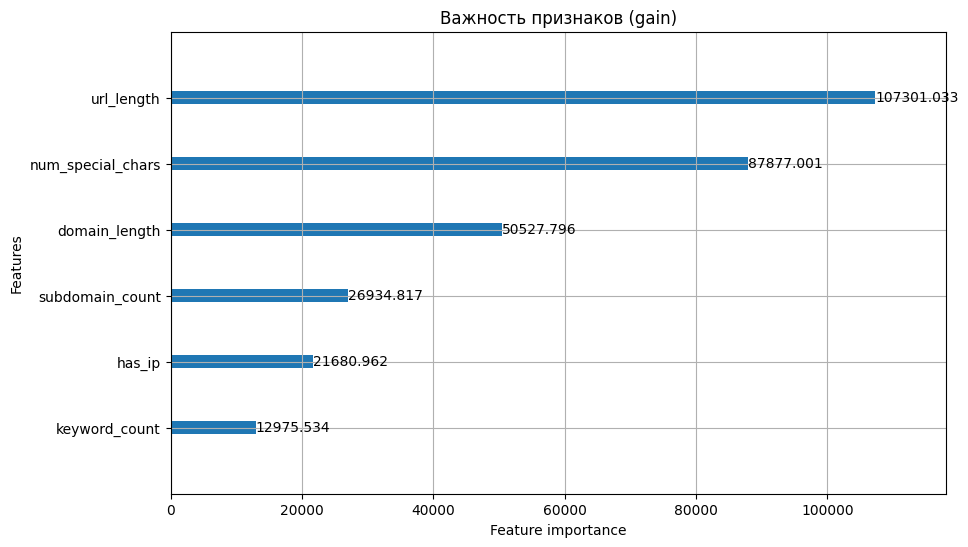

In [39]:
# Предсказание
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)  # Для бинарной классификации

# Метрики
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#print(f"\nROC-AUC: {roc_auc_score(y_test, y_pred_proba):.2f}")

# Важность признаков
lgb.plot_importance(model, figsize=(10, 6), importance_type="gain")
plt.title("Важность признаков (gain)")
plt.show()

In [32]:
def predict_url(url):
    features = extract_features(url)
    if not features:
        return "Ошибка обработки URL"
    features_df = pd.DataFrame([features])
    proba = model.predict(features_df)[0]
    return "Вредоносный" if proba > 0.5 else "Доброкачественный"

# Примеры
print(predict_url("http://malicious.com/login.exe"))  # Вредоносный
print(predict_url("https://google.com"))             # Доброкачественный

NotFittedError: Estimator not fitted, call fit before exploiting the model.